<center>
    <img src="./images/ac_header.png">
</center>

### <a target="_blank" rel="noopener noreferrer" href="https://www.tu-ilmenau.de/mt-ams/personen/schuller-gerald/">Prof. Dr. -Ing. Gerald Schuller</a> <br> <a target="_blank" rel="noopener noreferrer" href="https://www.tu-ilmenau.de/mt-ams/lehre/msp-and-adsp-tutorials/">Jupyter Notebook: Renato Profeta</a> 

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# PQMF Filter Bank, MPEG-1 / MPEG-2 BC Audio

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/yiPMDqBT7qk?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## The Basic Paradigm of T/F Domain Audio Coding

 <center>
    <br>
    <img src='./images/ac_06_01_blockdiagramAC.jpg' width='900'>
</center> 


## MPEG Audio Standardization Philosophy

Definition of a complete transmission chain consists of specification of:
 - Encoding algorithm
 - Bitstream format
 - Decoding algorithm
 
ITU-T Approach:
 - ITU-T standardizes all three parts
     - Encoder output predictable
     
MPEG Approach:
 - MPEG standardizes only bitstream format and decoder, 
     not the encoder (“informative part”)
     
Motivation: open for further improvements, room for specific corporate know-how

But: No sound quality guaranteed !

## MPEG 1/2

MPEG-1 Audio
- Audio coding 32 - 48 kHz, mono/stereo
- Layer 1, 2, 3
- Layer-3 (aka .mp3) optimized for lower bit-rates
- Copy protection via Serial Copy Management System (SCMS) included

MPEG-2 Audio
- Low sampling frequencies audio add 16 - 24 kHz to Layer 1, 2, 3
- Multichannel audio, BC (Backward Compatible)

### MPEG-1 Audio

Developed Dec. 88 to Nov. 92

Coding of mono and stereo signals

Bitrates from 32 kbit/s to 448 kbit/s

Three "Layers":
- Layer 1: lowest complexity
- Layer 2: increased complexity and quality
- Layer 3: highest complexity and quality at low bit-rates

Sampling frequencies supported:
- 48 kHz, 44.1 kHz, 32 kHz

#### The main building blocks

Perceptual model:
- using psychoacoustics, mostly proprietary

Filter bank:
- subdividing the input signal into spectral components
- more lines $\rightarrow$ more coding gain
- longer impulse response $\rightarrow$ pre-echo artifacts

Quantization and coding
- this is the step introducing quantization noise
- spectral shape of quantization noise determines the audibility
- can be designed to leave encoding methods optional

#### MPEG Audio - Short Description of the Layers

Layer I
- Frame length: 384 samples (8 ms@ 48 kHz)
- Frequency resolution: 32 subbands from a PQMF filter bank
- Quantization: Block-companding (12 samples), amplitude of subband samples indicated by “scalefactors” (SCF)

Layer II
- Frame length: 1152 samples (24 ms@ 48 kHz)
- Frequency resolution: 32 subbands from a PQMF filter bank
- Quantization: Block-companding (12 samples)
- Use of Scalefactor select information

Layer III
- Standard frame length: 1152 samples (24 ms @ 48 kHz)
- Frequency resolution: 576 or 192 subbands, from a 2-stage filter bank:
    - a 32-band PQMF filter bank in the first stage, followed by
    - a 6 or 18 band MDCT in each of the 32 PQMF subbands (hence 32*6=192, or 32*18=576) in the second stage.
- Quantization: non-uniform with Huffman coding
- Use of Scalefactor Select Information

##### Block Diagram MPEG-1 Layer 1

 <center>
    <br>
    <img src='./images/ac_06_02_mpeg1BlockDiag.jpg' width='900'>
</center> 

##### Block diagram Layer-3

 <center>
    <br>
    <img src='./images/ac_06_02_mpeg3BlockDiag.jpg' width='900'>
</center> 


## Example for the Time/Frequency Resolution for the 2-Stage Layer III Coder

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/fAZAjIBPHzk?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The first stage has a 32 subband QMF filter bank. For simplicity we only take an MDCT. We can visualize a 32 subband filter bank with our Python code.

In [3]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/4UWe3yQmWIs?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [4]:
# Imports and Configuration
%matplotlib inline
import numpy as np
import scipy.signal as signal
import pyaudio
import struct
import scipy.fftpack as spfft
from ipywidgets import ToggleButton, Button
from ipywidgets import HBox
import threading
import cv2

In [5]:
# Signal Processing Parameters

N=576                           # Number of subbands and block size
CHUNK_SIZE = N
FORMAT = pyaudio.paInt16       # Conversion format for PyAudio stream
CHANNELS = 1                   # Audio Channels
RATE = 32000                   # Sampling Rate in Hz
FFT_LEN = N                    # FFT Length  

rows=500
cols=CHUNK_SIZE
fftlen=cols
frame=0.0*np.ones((rows,cols,3));

In [6]:
#The D(z) matrix:
def Dmatrix(samples):
    #implementation of the delay matrix D(z)
    #Delay elements:
    out=np.zeros(N)
    out[0:int(N/2)]=Dmatrix.z
    Dmatrix.z=samples[0:int(N/2)]
    out[int(N/2):N]=samples[int(N/2):N]
    return out

Dmatrix.z=np.zeros(int(N/2))

In [7]:
#The inverse D(z) matrix:
def Dmatrixinv(samples):
    #implementation of the delay matrix D(z)
    #Delay elements:
    out=np.zeros(N)
    out[int(N/2):N]=Dmatrixinv.z
    Dmatrixinv.z=samples[int(N/2):N]
    out[0:int(N/2)]=samples[0:int(N/2)]
    return out

Dmatrixinv.z=np.zeros(int(N/2))

In [8]:
#The F Matrix:
fcoeff=np.sin(np.pi/(2*N)*(np.arange(0,2*N)+0.5))
Fmatrix=np.zeros((N,N))
Fmatrix[0:int(N/2),0:int(N/2)]=np.fliplr(np.diag(fcoeff[0:int(N/2)]))
Fmatrix[int(N/2):N,0:int(N/2)]=np.diag(fcoeff[int(N/2):N])
Fmatrix[0:int(N/2),int(N/2):N]=np.diag(fcoeff[N:int(N+N/2)])
Fmatrix[int(N/2):N,int(N/2):N]=-np.fliplr(np.diag(fcoeff[int(N+N/2):(2*N)]))

In [9]:
#The inverse F matrix:
Finv=np.linalg.inv(Fmatrix)

In [10]:
#The DCT4 transform:
def DCT4(samples):
    #use a DCT3 to implement a DCT4:
    samplesup=np.zeros(2*N)
    #upsample signal:
    samplesup[1::2]=samples
    y=spfft.dct(samplesup,type=3)/2
    return y[0:N]

In [11]:
#The complete MDCT, Analysis:
def MDCT(samples):
    y=np.dot(samples,Fmatrix)
    y=Dmatrix(y)
    y=DCT4(y)
    return y

In [12]:
#The inverse MDCT, synthesis:
def MDCTinv(y): 
    #inverse DCT4 is identical to DCT4:
    x=DCT4(y)*2/N
    #inverse D(z) matrix
    x=Dmatrixinv(x)
    #inverse F matrix
    x=np.dot(x,Finv)
    return x

In [13]:
# GUI
toggle_run = ToggleButton(description='Stop')
button_start= Button(description='Start')

def start_button(button_start):
    thread.start()
    button_start.disabled=True
button_start.on_click(start_button)


def on_click_toggle_run(change):
    if change['new']==False:
        stream.stop_stream()
        stream.close()
        p.terminate()
        cv2.destroyAllWindows()
toggle_run.observe(on_click_toggle_run, 'value')

box_buttons = HBox([button_start,toggle_run])

In [14]:
# Function to Plot MDCT

def run_mdct(toggle_run):
    while(True):
        if toggle_run.value==True:
            break
        
        #Reading from audio input stream into data with block length "CHUNK":
        data = stream.read(CHUNK_SIZE, exception_on_overflow = False)
        #Convert from stream of bytes to a list of short integers (2 bytes here) in "samples":
        #shorts = (struct.unpack( "128h", data ))
        shorts = (struct.unpack( 'h' * CHUNK_SIZE, data ));
        samples=np.array(list(shorts),dtype=float);

        #shift "frame" 1 up:
        frame[0:(rows-1),:]=frame[1:rows,:]; 
        #compute magnitude of 1D FFT of sound 
        #with suitable normalization for the display:
        #frame=np.abs(np.ffqt.fft2(frame[:,:,1]/255.0))/512.0
        #write magnitude spectrum in lowes row of "frame":
        #R=0.25*np.log((np.abs(np.fft.fft(samples[0:fftlen])[0:(fftlen/2)]/np.sqrt(fftlen))+1))/np.log(10.0)

        #This is the FFT of the input:
        #y=np.fft.fft(samples[0:fftlen])   
        #This is the analysis MDCT of the input: 
        y=MDCT(samples[0:fftlen])

        #yfilt is the processed subbands, processing goes here:
        yfilt=y

        #Waterfall color mapping:
        R=0.25*np.log((np.abs(yfilt/np.sqrt(fftlen))+1))/np.log(10.0)
        #Red frame:
        frame[rows-1,:,2]=R
        #Green frame:
        frame[rows-1,:,1]=np.abs(1-2*R)
        #Blue frame:
        frame[rows-1,:,0]=1.0-R
        #frame[rows-1,:,0]=frame[rows-1,:,1]**3
        # Display the resulting frame
        cv2.imshow('frame',frame)

        #Inverse FFT:
        #xrek=np.real(np.fft.ifft(yfilt))
        #Inverse/synthesis MDCT:
        xrek=MDCTinv(yfilt).astype(int);
        xrek=np.clip(xrek, -32000,32000)
        #converting from short integers to a stream of bytes in "data":
        #data=struct.pack('h' * len(samples), *samples);
        data=struct.pack('h' * len(xrek), *xrek);
        #Writing data back to audio output stream: 
        stream.write(data, CHUNK_SIZE)

        #Keep window open until key 'q' is pressed:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # When everything done, release the capture
    stream.stop_stream()
    stream.close()
    p.terminate()
    cv2.destroyAllWindows()

In [15]:
# Create a Thread for run_spectrogram function
thread = threading.Thread(target=run_mdct, args=(toggle_run,))

In [16]:
# Start Audio Stream
# Create 
p = pyaudio.PyAudio()
    
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                frames_per_buffer=CHUNK_SIZE)



input_data = stream.read(CHUNK_SIZE)
samples = np.frombuffer(input_data,np.int16)

In [17]:
# Initialize Plot and Display GUI
display(box_buttons)


**Observe:** We get a very **narrow spectrogram**, because we only have 32 subbands, but it **runs very fast**, because we donwsample only by 32. We can also **listen to a subband** (by setting the other subbands to zero), and we will hear more than just a tone, because the subbands are wider than for AAC.

Now set it to the number of subbands after the second stage:<br>
N=576

Here now it becomes more similar to the AAC filter bank. We see a **broader spectrogram**, but it **runs slower**, because we have an increased downsampling rate of 576.

The second layer does it by replacing every 12 or 18 time samples in each of the 32 subbands by 12 or 18 finer subbands.
When we now listen to a subband, it sound more like a tone, because the subbands are more narrow.

## MPEG - Layer-1, -2 and -3 Compression: Header

 <center>
    <br>
    <img src='./images/ac_06_04_mpegHeader.jpg' width='600'>
</center> 

**Observe:** The syncword allows decoding starting in the middle of the file, which is important for broadcast applications.

## The Pseudo-Quadrature-Mirror Filter Bank (PQMF)

In [31]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/uCgWiG7qZTQ?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The PQMF is also used for:
- parametric surround coding
- Parametric high frequency generation

The PQMF is a filter bank which has only "near" perfect reconstruction, unlike the MDCT, which has really perfect reconstruction.
- In the same sense it is near para-unitary or orthogonal, which means the synthesis filter are the time reversed analysis filters.
- But it has the advantage that we have design methods to design filter banks with "good" longer filters, with more overlap in time than we use with the MDCT. This results in improved nearby stopband attenuation.
- An often used configuration is 32 subbands with filters with length of 512 or 640 coefficients, hence 16 or 20-times overlap in time (compare that with 2-times overlap in the MDCT)

For that reason we now take a closer look at the PQMF filter bank:
(See also lecture slides Filter Banks 2)

In [18]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/q8aMPpb1YHI?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### PQMF Definition

The analysis filters of an N-band PQMF filter bank with filters of length L are defined as (see also Slides "Filter Banks 2"):

$$\large
 H_k(n) = h(n) \cos \left( \dfrac{\pi}{N} \cdot (k+0.5) \left(n-\dfrac{L}{2}+\dfrac{1}{2} \right) + \Phi_k \right)$$
 
 With the phase defined as:
 
 $$\large
 \Phi_{k+1}-\Phi_k=\dfrac{(2r+1)\pi}{2}$$
 
 With some integer r. For convenience we omit scaling factors.
 
 The synthesis filters are the time reverse analysis filters:
 
  $$\large
 g_k(n)=h_k(n)(L-1-n)$$
 
 (See also: https://ccrma.stanford.edu/~jos/sasp/Pseudo_QMF_Cosine_Modulation_Filter.html <br>
 Book: Spanias, Painter: “Audio Signal Processing and Coding”, Wiley Press)

In [20]:
%%html
<iframe src="https://ccrma.stanford.edu/~jos/sasp/Pseudo_QMF_Cosine_Modulation_Filter.html" width="900" height="600"></iframe>


### PQMF Reformulation

For the case of:

$$\large
\Phi_k = (-1)^{k+1}\cdot \frac{\pi}{4}$$

and

$$\large
\dfrac{L}{N} \mod 4 = \pm 2$$

We find that it is identical to our MDCT modulation function (with its time reversal now on the right side of the equation):

$$\large
h_k(n)=h(n) \cdot \cos \left( \dfrac{\pi}{N} \cdot \left( k + \dfrac{1}{2} \right)
\left(L-1-n+\dfrac{1}{2}-\dfrac{N}{2} \right)
\right) $$

### PQMF Design

Take the frequency response of the baseband prototype or window function:

$$\large
H(\omega) = DTFT(h(n))$$

Then we need to find (optimize) a function h(n), such that it fulfills:

- **Attenuation:** The **stopband attenuation** should be high after the neighboring band to **minimize aliasing (stop band)**:

$$\large
|H(w)| \approx 0 \text{ for } 1.5 \dfrac{\pi}{N} < |w| < \pi$$
(passband: 0...$0.5\dfrac{\pi}{N}$, transition band: $0.5\dfrac{\pi}{N}$...$1.5\dfrac{\pi}{N}$)

- **Unity condition (overlap region of 2 subbands):** Sum of magnitude squared frequency responses of **2 neighboring bands** should be close to a **constant**, here $2N^2$, to achieve **near perfect reconstruction**:

$$\large
|H(w)|^2 + \left| H\left(\dfrac{\pi}{N}-\omega\right)\right|^2 
\approx 2N^2 \text{ for } 0 \leq \omega \leq \dfrac{\pi}{N}
$$
(positive frequencies + flipped version)

### Python Example Optimization

To fulfill these requirements, we now have an **optimization problem**. Python has powerful optimization libraries to find a
solution. 

Take a very simple example: **find the minimum** of the function of 2 variables:

$$\large
f(x_1,x_2) = \sin(x_1) + \cos(x_2)$$

In [21]:
#function example with several unknowns (variables) for optimization
#Gerald Schuller, Nov. 2016

import numpy as np

def functionexamp(x):
    #x: array with 2 variables
    y=np.sin(x[0])+np.cos(x[1])
    return y

Next we use the library scipy.optimize to find a minimum, and use its function "minimize".

In [22]:
#Optimization example, see also:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html
#Gerald Schuller, Nov. 2016

import numpy as np
import scipy.optimize as optimize


#Example for 2 unknowns, args: function-name, starting point, method:

xmin=optimize.minimize(functionexamp,[-1.0,-3.0], method='CG')
print(xmin)

     fun: -1.9999999999888387
     jac: array([4.7236681e-06, 0.0000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([-1.5707916 , -3.14159265])


**Observe:** We indeed obtain the minimium at $x_1=\dfrac{−\pi}{2}, x_2=-\pi$

### PQMF Optimization, Python Example, Optimization Function

In [23]:
import numpy as np
import scipy as sp
import scipy.signal as sig

def optimfuncQMF(x):
    """Optimization function for a PQMF Filterbank
    x: coefficients to optimize (first half of prototype h because of symmetry)
    err: resulting total error"""
    N=4 #4 subbands
    h = np.append(x,np.flipud(x));
    f,H_im = sig.freqz(h)
    H=np.abs(H_im) #only keeping the magnitude
    posfreq = np.square(H[0:512//N]);
    #Negative frequencies are symmetric around 0:
    negfreq = np.flipud(np.square(H[0:512//N]))
    #Sum of magnitude squared frequency responses should be close to unity (or N)
    unitycond = np.sum(np.abs(posfreq+negfreq - 2*(N*N)*np.ones(512//N)))/512;
    #plt.plot(posfreq+negfreq);
    #High attenuation after the next subband:
    att = np.sum(np.abs(H[int(1.5*512/N):]))/512;
    #Total (weighted) error:
    err = unitycond + 100*att;
    return err

Now we have a function to minimize, and we can use Pythons powerful optimization library to minimize this function:

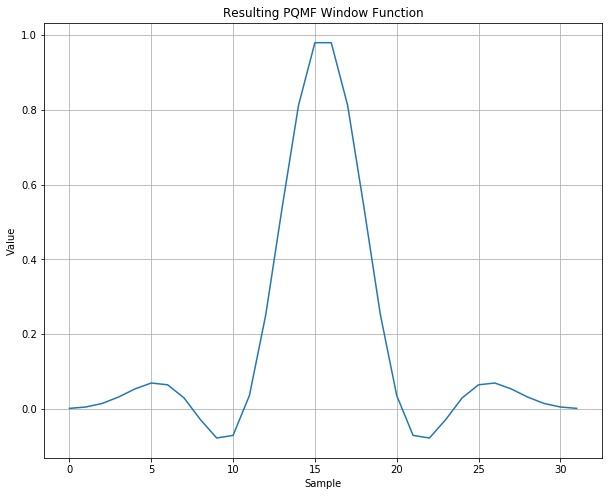

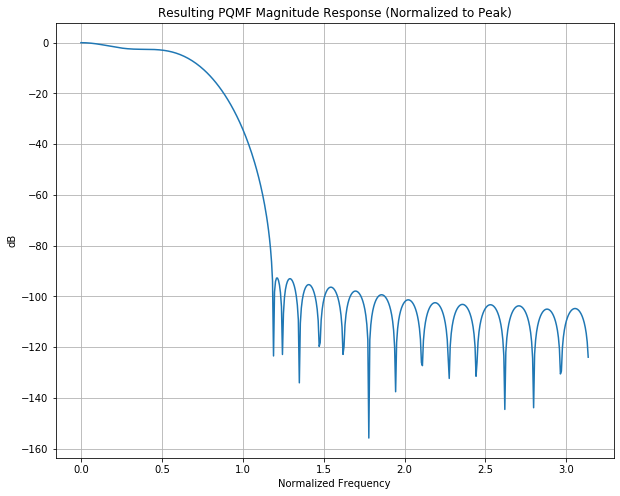

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig

#optimize for 16 filter coefficients:
xmin = opt.minimize(optimfuncQMF,16*np.ones(16),method='SLSQP')
xmin = xmin["x"]
#Restore symmetric upper half of window:
h = np.concatenate((xmin,np.flipud(xmin)))
plt.figure(figsize=(10,8))
plt.plot(h)
plt.title("Resulting PQMF Window Function")
plt.ylabel("Value")
plt.xlabel("Sample")
plt.grid()
f,H = sig.freqz(h)
plt.figure(figsize=(10,8))
mag = np.abs(H)/np.abs(H).max()
plt.plot(f,20*np.log10(mag))
plt.title("Resulting PQMF Magnitude Response (Normalized to Peak)")
plt.xlabel("Normalized Frequency")
plt.ylabel("dB")
plt.grid()

**Observe:** We get almost 100 dB Stopband attenuation, much more than with the MDCT!

### PQMF Optiization, Python Example, Unity Condition

We can test the PQMF Unity condition:

$$\large
|H(w)|^2 + \left| H\left(\dfrac{\pi}{N}-\omega\right)\right|^2 
\approx 2N^2 \text{ for } 0 \leq \omega \leq \dfrac{\pi}{N}
$$

($2N^2=32$), with the following Python code:

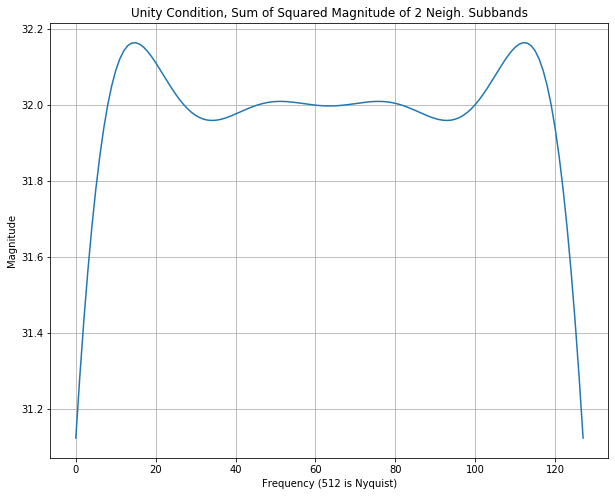

In [30]:
N=4
f,H = sig.freqz(h)
posfreq = np.square(H[0:512//N]);
negfreq = np.flipud(np.square(H[0:512//N]))
plt.figure(figsize=(10,8))
plt.plot(np.abs(posfreq)+np.abs(negfreq))
plt.xlabel('Frequency (512 is Nyquist)')
plt.ylabel('Magnitude')
plt.title('Unity Condition, Sum of Squared Magnitude of 2 Neigh. Subbands')
plt.grid()

**Observe:** We get indeed a curve close to $2N^2=32$, but with some Deviation, which shows that we get indeed only "near" Perfect Reconstruction!

**Observe:** We obtain a 4-band filter bank with filter length of 32 taps, hence 8 times overlap.

- The stopband attenuation reaches almost 100 dB, almost right after the passband, much more than with the MDCT!

### PQMF Optimization, Polyphase Implementation, Analysis and Synthesis

In [32]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/o5Bea-hAT6Y?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The advantage of having the same modulation function as the MDCT is that we can take the same type of filter matrices to implement it efficiently. The analysis filter matrix F_a is now:

 <center>
    <br>
    <img src='./images/ac_06_05_FaMetraix.jpg' width='700'>
    <br>
</center>

The synthesis filter matrix F_s is:

<center>
    <br>
    <img src='./images/ac_06_06_FsMetraix.jpg' width='700'>
    <br>
</center>

All together we obtain for the analysis filter bank (see also slides Filter Banks 1, with **T** the DCT transform matrix):


$$\large
Y(z) = X(z) \cdot F_a(z) \cdot T$$

For the reconstruction of synthesis filter bank we got:

$$\large
\hat{X}(z)=Y(z)\cdot T^{-1}\cdot F_s(z)$$

This formulation can also be used for the implementation of the PQMF filter bank.

## Hybrid Filter Bank & Aliasing

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/JdA-UOM2_pg?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

 <center>
    <br>
    <img src='./images/ac_06_07_hybrid1.jpg' width='700'>
    <br>
</center>
<center>
    <br>
    <img src='./images/ac_06_08_hybrid2.jpg' width='700'>
    <br>
</center>
<center>
    <br>
    <img src='./images/ac_06_09_hybrid3.jpg' width='700'>
    <br>
</center>

### Problem of Aliasing in a Cascaded Filter Bank

<center>
    <br>
    <img src='./images/ac_06_10_hybrid4.jpg' width='700'>
    <br>
</center>
<center>
    <br>
    <img src='./images/ac_06_11_hybrid5.jpg' width='700'>
    <br>
</center>

### Aliasing Reduction Structure (MP3)

<center>
    <br>
    <img src='./images/ac_06_12_hybrid6.jpg' width='700'>
    <br>
</center>

## MPEG Audio - Layer-3: Bitstream

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/7BZvAKYhf3U?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Organization of the bit streams:

Fixed length of bytes: 17 at mono, 32 at stereo, independent of the bitrate.

Constant Section:
- Header (ISO Standard, like with Layer-1 and -2)
-  Additional information for a frame (e.g. Pointer to the variable section)
-  Additional information for each “granule” (e.g. Number of the Huffman-Code table)

Variable Section:
-  Scalefactors
-  Huffman-coded frequency lines
-  Additional Data

<center>
    <br>
    <img src='./images/ac_06_13_bitstream.jpg' width='900'>
    <br>
</center>

## MPEG-1 Audio Decoder

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/FyukU2khfcQ?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### MPEG Audio – General Decoder Structure

<center>
    <br>
    <img src='./images/ac_06_14_decoder.jpg' width='900'>
    <br>
</center>


### MPEG - Audio Decoder Process (1) Layer-3 Decoder flow chart

<center>
    <br>
    <img src='./images/ac_06_15_flowchart.jpg' width='900'>
    <br>
</center>


### MPEG - Audio Decoder Process Layer-3 Decoder Diagramm

<center>
    <br>
    <img src='./images/ac_06_16_layer3Diag.jpg' width='900'>
    <br>
</center>


#### Annex: Abbreviations and Companies

- AAC: Advanced Audio Coding
- ASPEC: Adaptive Spectral Perceptual Entropy Coding
- AT&T: American Telephone and Telegraph Company
- CCETT: Centre Commun d’Etudes de Télédiffusion et Télécommunication
- CNET: Research and Development Center of France Télécom
- FhG-IIS: Fraunhofer Gesellschaft/Institut für Integrierte Schaltungen (Erlangen)
- IRT: Institut für Rundfunktechnik GmbH, München, Research and Development Institute of ARD, ZDF, DLR, ORF and SRG
- ITU-R: International Telecommunication Union – Radio Communication Sector
- MASCAM: Masking-pattern Adapted Subband Coding and Multiplexing AT&T:American Telephone and Telegraph Company
- MUSICAM: Masking-pattern Universal Subband Integrated Coding and Multiplexing
- NTT: Nippon Telegraph and Telephone Corp./Human Interface Laboratories
- Thomson: Thomson, Telefunken, Saba, RCA, GE, ProScan
- TwinVQ: Transform-domain Weighted Interleave Vector Quantization